# Formulation of a directional damage-plasticity model

In [1]:
%matplotlib widget
import numpy as np
import bmcs_utils
from bmcs_matmod.slide.slide_explorer import SlideExplorer
import bmcs_utils.api as bu
from bmcs_matmod.time_fn.time_function import TimeFunction
import matplotlib.pylab as plt

## Helmholtz free energy function

The Helmholtz free energy function must have a shape like the following:

$$
\rho {\psi}(\varepsilon_{ij},\varepsilon_{ij}^p,\omega_\mathrm{N}, \omega_\mathrm{T})
= \frac{1}{2} \varepsilon_{ij} D_{ijkl} \varepsilon_{kl}
-
 \frac{1}{2} \varepsilon_{kl} n_k n_l E n_i n_j \varepsilon_{ij}
+
 \frac{1}{2} (\varepsilon_{kl} - \varepsilon_{kl}^p) n_k n_l n_i n_j (1 - \omega_\mathrm{N}) D_{ijkl} n_k n_l n_i n_j (\varepsilon_{ij} - \varepsilon_{ij}^p) 
- 
 \frac{1}{16} (n_j \delta_{ki} + n_k \delta_{ji} - 2n_j n_k n_i) \varepsilon_{jk} n_j  D_{ijkl} (n_i \delta_{jk} + n_j \delta_{ik} - 2n_i n_j n_k) \varepsilon_{ij} n_l
+
 \frac{1}{16} (n_j \delta_{ki} + n_k \delta_{ji} - 2n_j n_k n_i) (\varepsilon_{jk} - \varepsilon_{jk}^p) n_j (1 - \omega_\mathrm{T}) D_{ijkl} (n_i \delta_{jk} + n_j \delta_{ik} - 2n_i n_j n_k) (\varepsilon_{ij} - \varepsilon_{ij}^p) n_l
$$

The displayed formulation presents two problems: 
- The result of $\varepsilon_{kl} n_k n_l n_i n_j D_{ijkl} n_k n_l n_i n_j$ does not cancel the stress normal to the plane defined by the normal vector $n_i$. In this case $\varepsilon_\mathrm{N} = \varepsilon_{kl} n_k n_l$ and $E_\mathrm{N} =D_{ijkl} n_k n_l n_i n_j$. The problem is that $E_\mathrm{N} \varepsilon_\mathrm{N} \neq \sigma_{11} $
- For the tangential component this Helmholtz free energy function is not delivering simetric tangential part of the stress tensor

Actual state of the desirable expression for the stress tensor

$$
 \sigma_{ij} = \frac{\partial \rho \psi}{ \partial \varepsilon_{ij} }
$$

$$
\sigma_{ij} =     
D_{ijkl} \varepsilon_{kl} 
- 
\varepsilon_\mathrm{N} n_{i} n_{j} E_\mathrm{N}
+ 
(\varepsilon_\mathrm{N} - \varepsilon_\mathrm{N}^p) n_{i} n_{j} (1 - \omega_\mathrm{N}) E_\mathrm{N}
-
(\varepsilon_{\mathrm{T}_i} n_j + n_i \varepsilon_{\mathrm{T}_j})  E_\mathrm{T}
+
 ((\varepsilon_{\mathrm{T}_i} n_j + n_i \varepsilon_{\mathrm{T}_j} ) - (\varepsilon_{\mathrm{T}_i}^p n_j + n_i \varepsilon_{\mathrm{T}_j}^p ))  (1 - \omega_\mathrm{T}) E_\mathrm{T}
$$

with $$ \varepsilon_{\mathrm{N}} = \varepsilon_{ij} n_i n_j, \\ E_\mathrm{N} = E , \\ \varepsilon_{\mathrm{T}_k} = \frac{1}{2}\left[n_i \delta_{jk} + n_j \delta_{ik} - 2 n_i n_j n_k \right] \varepsilon_{ij}, \\  E_\mathrm{T} = D_{ijkl} \frac{1}{2}\left[n_i \delta_{jk} + n_j \delta_{ik} - 2 n_i n_j n_k \right] n_l
$$

**TODO** : 

- solve the issues with the Helmholtz free energy function

- compute algorithmic tangent operator

With the presented expression for the stress tensor and extracting the desired strain components from the strain tensor, it is possible to couple the SLIDE machinery to the model and obtain a tensorial material model out of it.

## Implementation on a strain-driven simulation

The strategy consists on creating three loading scenarios, where the strain tensor can be "artificially created". The three loading cases are:
- Uniaxial tension
- Uniaxial compression
- Pure shear

Since several expresions are going to be the same for all the studied cases:

In [2]:
def get_eps_N(eps_ij, n_i):
    eps_N = np.einsum('...ij,...i,...j->...', eps_ij, n_i, n_i)
    return eps_N

In [3]:
def get_eps_T(eps_ij, n_i):
    delta_ij = np.identity(3)
    eps_T = 0.5*(np.einsum('...i,...jk,...ij->...k',n_i,delta_ij,eps_ij) 
                 + np.einsum('...j,...ik,...ij->...k',n_i,delta_ij,eps_ij) 
                 - 2*np.einsum('...i,...j,...k,...ij->...k',n_i,n_i,n_i,eps_ij))
    return eps_T

In [4]:
def get_eps_T_p(eps_T_p, eps_T):
    director_vector = eps_T[-1] / np.linalg.norm(eps_T[-1])
    eps_T_p = np.einsum('...,...i->...i',eps_T_p, director_vector) 
    return eps_T_p

In [5]:
def get_D_ijkl(E,nu):
    delta_ij = np.identity(3)
    la = E * nu / ((1. + nu) * (1. - 2. * nu))
    mu = E / (2. + 2.* nu)
    D_ijkl = (np.einsum(',ij,kl->ijkl', la, delta_ij, delta_ij) +
              np.einsum(',ik,jl->ijkl', mu, delta_ij, delta_ij) +
              np.einsum(',il,jk->ijkl', mu, delta_ij, delta_ij))
    return D_ijkl

In [6]:
def get_E_T(E,nu,n_i):
    delta_ij = np.identity(3)
    D_ijkl = get_D_ijkl(E,nu)
    operator = 0.5*(np.einsum('i,jk,l->ijkl',n_i,delta_ij,n_i) 
                 + np.einsum('j,ik,l->jikl',n_i,delta_ij,n_i) 
                 - 2*np.einsum('i,j,k,l->ijkl',n_i,n_i,n_i,n_i))
    E_T = np.einsum('ijkl,ijkl->', D_ijkl, operator)
    return E_T

In [7]:
def get_sigma(E, nu, n_i, eps_ij, eps_N_p, omega_N, eps_T_p, omega_T):
    
    eps_N = get_eps_N(eps_ij, n_i)
    eps_T = get_eps_T(eps_ij, n_i)
    D_ijkl = get_D_ijkl(E,nu)
    E_T = get_E_T(E,nu,n_i) 
    sigma_ij = (np.einsum( '...ijkl,...kl->...ij',D_ijkl, eps_ij) 
                - np.einsum( '...,...i,...j->...ij', eps_N, n_i, n_i) * E 
                + np.einsum( '...,...i,...j,...->...ij', (eps_N - eps_N_p) , n_i, n_i, (1-omega_N)* E)
                - E_T*(np.einsum('...i,...j->...ij', n_i, eps_T) + np.einsum('...i,...j->...ij', eps_T, n_i))
                + (np.einsum('...,...i,...j->...ij', (1 - omega_T)*E_T, n_i, (eps_T - eps_T_p)) + np.einsum('...,...i,...j->...ij', (1 - omega_T)*E_T, (eps_T - eps_T_p), n_i)) 
               )  
    return sigma_ij

### Uniaxial tension - strain controlled

Constructing the strain tensor in n steps and getting stress tensor via SLIDE model

In [10]:
E = 1
nu = 0.2

In [11]:
n_steps = 100
eps_ij = np.zeros((n_steps,3,3))
eps11 = np.linspace(0,1,n_steps)
#eps22 = eps33 = np.linspace(0,-0.2,n_steps)
eps22 = eps33 = -nu*eps11
eps_ij[:,0,0] = eps11
eps_ij[:,1,1] = eps22
eps_ij[:,2,2] = eps33

In [12]:
n_i = [1,0,0] 

In [13]:
material_params = dict(
    E_T=get_E_T(E,nu,n_i), gamma_T=0, K_T=0, S_T=0.05, c_T=3, bartau=0.2, 
    E_N=E, S_N=0.0001, c_N = 1, m = 0.1, f_t=0.1, f_c=2, f_c0=1, eta=0.0)

se1 = SlideExplorer( n_steps=n_steps-1, k_max=50)
se1.slide_model.trait_set(**material_params)
se1.trait_set(s_x_1 =  0.0, s_y_1 = 0, w_1 = eps11[-1]);
se1.run()

In [14]:
sigma_T, tau_y_pi_, sig_N, Z_, X_x_, X_y_, Y_T_, Y_N_ = se1.Sig_arr.T
eps_T_p, s_y_pi_, eps_N_p, z_, alpha_x_, alpha_y_, omega_T, omega_N = se1.Eps_arr.T
eps_T = get_eps_T(eps_ij, n_i)
eps_T_p = get_eps_T_p(eps_T_p, eps_T)

C:\Users\marag\AppData\Local\Temp/ipykernel_15156/2029371827.py:2: RuntimeWarning: invalid value encountered in true_divide
  director_vector = eps_T[-1] / np.linalg.norm(eps_T[-1])


In [17]:
sigma_ij = get_sigma(E, nu, n_i, eps_ij, eps_N_p, omega_N, eps_T_p, omega_T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
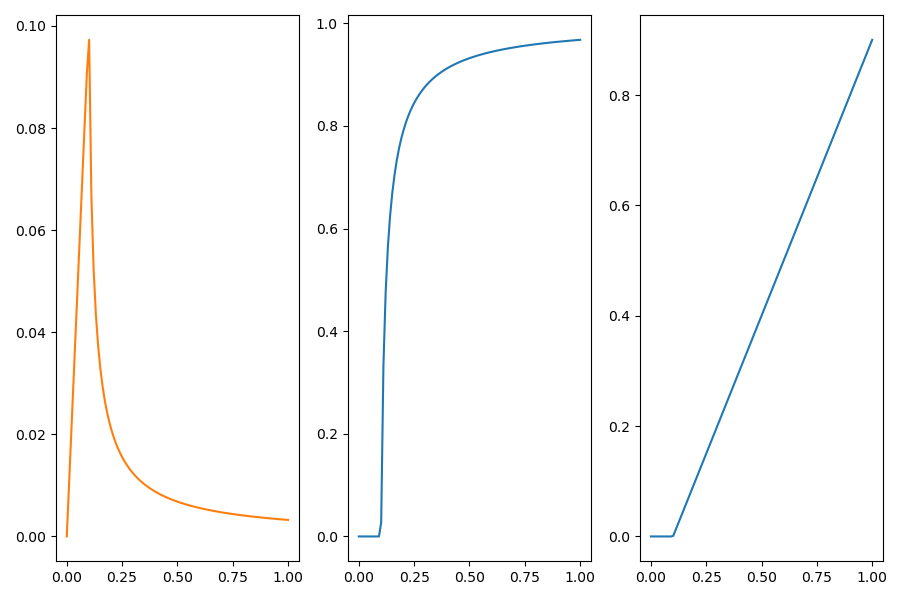

In [18]:
fig, ((ax_1, ax_2, ax_3)) = plt.subplots(1,3, tight_layout=True, figsize=(9,6))

ax_1.plot(eps_ij[:,0,0] , sigma_ij[:,0,0])
ax_1.plot(eps_ij[:,0,0] , sig_N)

ax_2.plot(eps_ij[:,0,0] , omega_N)

ax_3.plot(eps_ij[:,0,0] , eps_N_p)

### Uniaxial compression - strain controlled

Constructing the strain tensor in n steps and getting stress tensor via SLIDE model

In [19]:
n_i = [1,0,0] 

In [20]:
E = 1
nu = 0.2

In [21]:
n_steps =100
strain = -3
eps_ij = np.zeros((n_steps,3,3))
eps11 = np.linspace(0,strain,n_steps)
eps22 = eps33 = np.linspace(0,-nu*strain,n_steps)
eps_ij[:,0,0] = eps11
eps_ij[:,1,1] = eps22
eps_ij[:,2,2] = eps33

In [22]:
material_params = dict(
    E_T=get_E_T(E,nu,n_i), gamma_T=0, K_T=0, S_T=0.05, c_T=3, bartau=0.2, 
    E_N=E, S_N=0.0001, c_N = 1, m = 0.1, f_t=0.1, f_c=2, f_c0=1, eta=0.0)

se1 = SlideExplorer( n_steps=n_steps-1, k_max=50)
se1.slide_model.trait_set(**material_params)
se1.trait_set(s_x_1 =  0.0, s_y_1 = 0, w_1 = eps11[-1]);
se1.run()

In [23]:
sigma_T, tau_y_pi_, sig_N, Z_, X_x_, X_y_, Y_T_, Y_N_ = se1.Sig_arr.T
eps_T_p, s_y_pi_, eps_N_p, z_, alpha_x_, alpha_y_, omega_T, omega_N = se1.Eps_arr.T
eps_T = get_eps_T(eps_ij, n_i)
eps_T_p = get_eps_T_p(eps_T_p, eps_T)

C:\Users\marag\AppData\Local\Temp/ipykernel_15156/2029371827.py:2: RuntimeWarning: invalid value encountered in true_divide
  director_vector = eps_T[-1] / np.linalg.norm(eps_T[-1])


In [24]:
sigma_ij = get_sigma(E, nu, n_i, eps_ij, eps_N_p, omega_N, eps_T_p, omega_T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
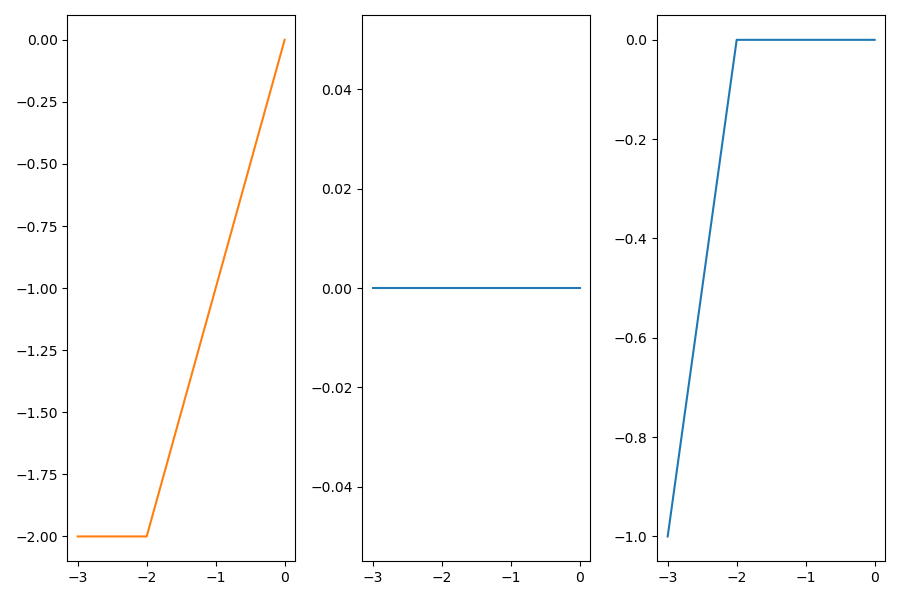

In [25]:
fig, ((ax_1, ax_2, ax_3)) = plt.subplots(1,3, tight_layout=True, figsize=(9,6))

ax_1.plot(eps_ij[:,0,0] , sigma_ij[:,0,0])
ax_1.plot(eps_ij[:,0,0] , sig_N)

ax_2.plot(eps_ij[:,0,0] , omega_N)

ax_3.plot(eps_ij[:,0,0] , eps_N_p)

### Pure shear - strain controlled

Constructing the strain tensor in n steps and getting stress tensor via SLIDE model

In [26]:
n_i = [1,0,0] 

In [27]:
E = 1
nu = 0.2

In [28]:
n_steps =100
strain = 5
eps_ij = np.zeros((n_steps,3,3))
eps13= eps31 = np.linspace(0,strain,n_steps)
eps_ij[:,0,2] = eps13
eps_ij[:,2,0] = eps31

In [29]:
material_params = dict(
    E_T=get_E_T(E,nu,n_i), gamma_T=10, K_T=0, S_T=0.05, c_T=1, bartau=0.2, 
    E_N=E, S_N=0.0001, c_N = 1, m = 0.1, f_t=0.1, f_c=2, f_c0=1, eta=0.0)

se1 = SlideExplorer( n_steps=n_steps-1, k_max=50)
se1.slide_model.trait_set(**material_params)
se1.trait_set(s_x_1 = strain, s_y_1 = 0, w_1 = 0);
se1.run()

In [30]:
sigma_T, tau_y_pi_, sig_N, Z_, X_x_, X_y_, Y_T_, Y_N_ = se1.Sig_arr.T
eps_T_p, s_y_pi_, eps_N_p, z_, alpha_x_, alpha_y_, omega_T, omega_N = se1.Eps_arr.T
eps_T = get_eps_T(eps_ij, n_i)
eps_T_p_i = get_eps_T_p(eps_T_p, eps_T)

In [31]:
sigma_ij = get_sigma(E, nu, n_i, eps_ij, eps_N_p, omega_N, eps_T_p_i, omega_T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
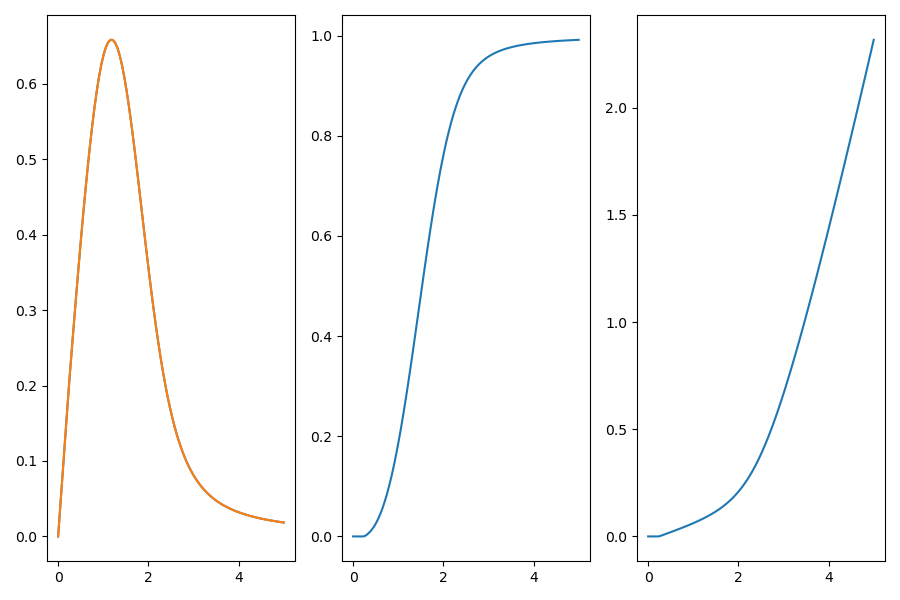

In [32]:
fig, ((ax_1, ax_2, ax_3)) = plt.subplots(1,3, tight_layout=True, figsize=(9,6))

ax_1.plot(eps_ij[:,0,2] , sigma_ij[:,0,2])
ax_1.plot(eps_ij[:,0,2] , sigma_T)


ax_2.plot(eps_ij[:,0,2] , omega_T)

ax_3.plot(eps_ij[:,0,2] , eps_T_p)

Trying to obtain damage tensor $\beta_{ijkl} = \phi_{ik} \phi_{jl}^T$

$\phi_{ij} = \begin{bmatrix}
\sqrt{1-\omega_{\mathrm{N}}} & 0 & 0\\
0 & \sqrt{1-\omega_{\mathrm{T}_y}} & 0\\
0 & 0 & \sqrt{1-\omega_{\mathrm{T}_z}}
\end{bmatrix}$

In [33]:
phi_ij = np.zeros_like(eps_ij)
phi_ij[:,1,1] = 0.
phi_ij[:,2,2] = np.sqrt(1-omega_T)
phi_ij[:,0,0] = np.sqrt(1-omega_N)

In [34]:
beta_ijkl = np.einsum('...ik,...jl->...ijkl',phi_ij,np.transpose(phi_ij,(0,2,1)))

In [35]:
eps_ij_p = (np.einsum('...i,...j->...ij', n_i, eps_T_p_i) + np.einsum('...i,...j->...ij', eps_T_p_i, n_i)) + np.einsum( '...,...i,...j->...ij', eps_N_p, n_i, n_i)
eps_N_p[-1]

0.020342384075648683

In [36]:
E_T = get_E_T(E,nu,n_i) 

In [37]:
sigma_ij_2 = np.einsum('...ijkl,...klrs,...rstu,...tu->...ij',beta_ijkl,get_D_ijkl(E,nu),beta_ijkl,(eps_ij-eps_ij_p))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
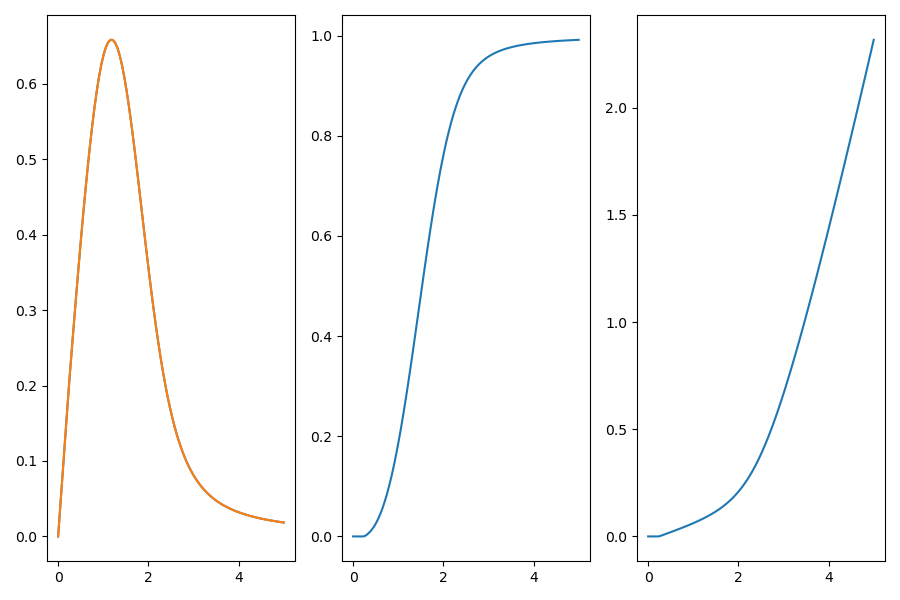

In [38]:
fig, ((ax_1, ax_2, ax_3)) = plt.subplots(1,3, tight_layout=True, figsize=(9,6))

ax_1.plot(eps_ij[:,0,2] , sigma_ij[:,0,2])
ax_1.plot(eps_ij[:,0,2] , sigma_ij_2[:,0,2])


ax_2.plot(eps_ij[:,0,2] , omega_T)

ax_3.plot(eps_ij[:,0,2] , eps_T_p)

## Implementation on a stress-driven simulation

In [27]:
import traits.api as tr

class MATS3DSlide():
    # -------------------------------------------------------------------------
    # Cached elasticity tensors
    # -------------------------------------------------------------------------

    E = tr.Float(1,
                 label="E",
                 desc="Young's Modulus",
                 auto_set=False,
                 input=True)

    nu = tr.Float(0.2,
                  label='nu',
                  desc="Poison ratio",
                  auto_set=False,
                  input=True)
    
    def get_D_ijkl(self,E,nu):
        delta_ij = np.identity(3)
        la = E * nu / ((1. + nu) * (1. - 2. * nu))
        mu = E / (2. + 2.* nu)
        D_ijkl = (np.einsum(',ij,kl->ijkl', la, delta_ij, delta_ij) +
                  np.einsum(',ik,jl->ijkl', mu, delta_ij, delta_ij) +
                  np.einsum(',il,jk->ijkl', mu, delta_ij, delta_ij))
        return D_ijkl
    
    def get_eps_N(self,eps_ij, n_i):
        eps_N = np.einsum('...ij,...i,...j->...', eps_ij, n_i, n_i)
        return eps_N

    def get_eps_T(self,eps_ij, n_i):
        delta_ij = np.identity(3)
        eps_T = 0.5*(np.einsum('...i,...jk,...ij->...k',n_i,delta_ij,eps_ij) 
                     + np.einsum('...j,...ik,...ij->...k',n_i,delta_ij,eps_ij) 
                     - 2*np.einsum('...i,...j,...k,...ij->...k',n_i,n_i,n_i,eps_ij))
        return eps_T

    def get_eps_T_p(self,eps_T_p, eps_T):
        director_vector = [0,0,1]
        eps_T_p = np.einsum('...,...i->...i',eps_T_p, director_vector) 
        return eps_T_p
    
    def get_E_T(self,E,nu,n_i):
        delta_ij = np.identity(3)
        D_ijkl = self.get_D_ijkl(E,nu)
        operator = 0.5*(np.einsum('i,jk,l->ijkl',n_i,delta_ij,n_i) 
                     + np.einsum('j,ik,l->jikl',n_i,delta_ij,n_i) 
                     - 2*np.einsum('i,j,k,l->ijkl',n_i,n_i,n_i,n_i))
        E_T = np.einsum('ijkl,ijkl->', D_ijkl, operator)
        return E_T

    # -------------------------------------------------------------------------
    # Evaluation - get the corrector and predictor
    # -------------------------------------------------------------------------

    def get_corr_pred(self, eps_ij, n_i, se1):
        
        E = 1
        nu= 0.2
        
        eps_N = np.einsum('...ij,...i,...j->...', eps_ij, n_i, n_i)
        eps_T = self.get_eps_T(eps_ij, n_i)
        
        material_params = dict(
            E_T=self.get_E_T(E,nu,n_i), gamma_T=10, K_T=0, S_T=0.05, c_T=1, bartau=0.2, 
            E_N=E, S_N=0.0001, c_N = 1, m = 0.1, f_t=0.1, f_c=2, f_c0=1, eta=0.0)

        se1 = SlideExplorer( n_steps=1, k_max=50)
        se1.slide_model.trait_set(**material_params)
        se1.trait_set(s_x_1 = np.linalg.norm(eps_T), s_y_1 = 0, w_1 = eps_N);
        se1.run()
        
        sigma_T, tau_y_pi_, sig_N, Z_, X_x_, X_y_, Y_T_, Y_N_ = se1.Sig_arr.T
        eps_T_p, s_y_pi_, eps_N_p, z_, alpha_x_, alpha_y_, omega_T, omega_N = se1.Eps_arr.T
        eps_T = self.get_eps_T(eps_ij, n_i)
        eps_T_p_i = self.get_eps_T_p(eps_T_p[-1], eps_T)
        
        phi_ij = np.zeros_like(eps_ij)
        phi_ij[1,1] = 0.
        phi_ij[2,2] = np.sqrt(1-omega_T[-1])
        phi_ij[0,0] = np.sqrt(1-omega_N[-1])

        beta_ijkl = np.einsum('...ik,...jl->...ijkl',phi_ij,np.transpose(phi_ij,(1,0)))

        eps_ij_p = (np.einsum('...i,...j->...ij', n_i, eps_T_p_i) + np.einsum('...i,...j->...ij', eps_T_p_i, n_i)) + np.einsum( '...,...i,...j->...ij', eps_N_p[-1], n_i, n_i)
        
        delta_ij = np.identity(3)
        
        la = E * nu / ((1. + nu) * (1. - 2. * nu))
        mu = E / (2. + 2.* nu)
        D_abef = (np.einsum(',ij,kl->ijkl', la, delta_ij, delta_ij) +
                  np.einsum(',ik,jl->ijkl', mu, delta_ij, delta_ij) +
                  np.einsum(',il,jk->ijkl', mu, delta_ij, delta_ij))
    

        D_ijkl = np.einsum('ijkl,klrs,rstu->ijtu',beta_ijkl,D_abef,beta_ijkl)

        sigma_ij = np.einsum('...ijkl,...kl->...ij',D_ijkl,(eps_ij-eps_ij_p))
        

        return D_ijkl, sigma_ij, eps_ij_p, se1

    # -----------------------------------------------
    # number of microplanes - currently fixed for 3D
    # -----------------------------------------------
    
    def _get_lame_params(self):
        la = self.E * self.nu / ((1. + self.nu) * (1. - 2. * self.nu))
        # second Lame parameter (shear modulus)
        mu = self.E / (2. + 2. * self.nu)
        return la, mu

    D_abef = tr.Property(tr.Array, depends_on='+input')

    @tr.cached_property
    def _get_D_abef(self):
        la = self._get_lame_params()[0]
        mu = self._get_lame_params()[1]
        delta = np.identity(3)
        D_abef = (np.einsum(',ij,kl->ijkl', la, delta, delta) +
                  np.einsum(',ik,jl->ijkl', mu, delta, delta) +
                  np.einsum(',il,jk->ijkl', mu, delta, delta))

        return D_abef

In [31]:
DELTA = np.identity(3)

EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1


DD = np.hstack([DELTA, np.zeros_like(DELTA)])
EEPS = np.hstack([np.zeros_like(EPS), EPS])

GAMMA = np.einsum(
    'ik,jk->kij', DD, DD
) + np.einsum(
    'ikj->kij', np.fabs(EEPS)
)


def get_eps_ab(eps_O): return np.einsum(
    'Oab,...O->...ab', GAMMA, eps_O
)[np.newaxis, ...]


GAMMA_inv = np.einsum(
    'aO,bO->Oab', DD, DD
) + 0.5 * np.einsum(
    'aOb->Oab', np.fabs(EEPS)
)


def get_sig_O(sig_ab): return np.einsum(
    'Oab,...ab->...O', GAMMA_inv, sig_ab
)[0, ...]


GG = np.einsum(
    'Oab,Pcd->OPabcd', GAMMA_inv, GAMMA_inv
)


def get_K_OP(D_abcd):
    return np.einsum(
        'OPabcd,abcd->OP', GG, D_abcd
    )

def get_UF_t(F, n_t):

    material_params = dict(
            E_T=1, gamma_T=10, K_T=0, S_T=0.05, c_T=1, bartau=0.2, 
            E_N=1, S_N=0.0001, c_N = 1, m = 0.1, f_t=0.1, f_c=2, f_c0=1, eta=0.0)

    se = SlideExplorer(n_steps=1, k_max=50)
    se.slide_model.trait_set(**material_params)
    se.trait_set(s_x_1 =0, s_y_1 = 0, w_1 = 0);
    se.run()
    n_i = [1,0,0]
    
    D = np.zeros((3, 3, 3, 3))
    D = D[np.newaxis, :, :, :, :]

    # total number of DOFs
    n_O = 6
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    U_P = np.zeros((n_O,), np.float_)
    eps_aux = get_eps_ab(U_k_O)
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_aux, t_n1, t_max, t_step = 0, 0, len(F), 1 / n_t
    # Iteration parameters
    k_max, R_acc = 1000, 1e-3
    # Record solutions
    U_t_list, F_t_list, U_P_list = [np.copy(U_k_O)], [np.copy(F_O)], [np.copy(U_P)]

    # Load increment loop
    while t_n1 <= t_max - 1:

        F_ext[0] = F[t_n1]
        F_ext[1] = 0. * F[t_n1]
        F_ext[2] = 0. * F[t_n1]

        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O).reshape(3, 3)
            # Stress and material stiffness

            D_abcd, sig_ab, eps_p_Emab, se1 = m.get_corr_pred(
                eps_ab, n_i, se
            )
            # Internal force
            F_O = get_sig_O(sig_ab.reshape(1,3,3)).reshape(6,)
            # Residuum
            R_O = F_ext - F_O
            # System matrix
            K_OP = get_K_OP(D_abcd)
            # Convergence criterion
            R_norm = np.linalg.norm(R_O)
            delta_U_O = np.linalg.solve(K_OP, R_O)
            U_k_O += delta_U_O
            if R_norm < R_acc:
                # Convergence reached
                break
            # Next iteration
            k += 1

        else:
            print('no convergence')

            break

        # Update states variables after convergence
        int_var = m._x_get_state_variables(eps_ab, int_var, eps_aux)

        
        t_n1 += 1

    U_t, F_t = np.array(U_t_list), np.array(F_t_list)
    return U_t, F_t

In [32]:
m = MATS3DSlide()
t_steps_cycle = 100



load = np.linspace(0,0.07,t_steps_cycle)

U, F = get_UF_t(
    load, t_steps_cycle)

LinAlgError: Singular matrix

## Checking the tensors

In [43]:
eps_ab = np.zeros((3,3))
eps_ab[0,0] = 1
eps_ab[1,1] = eps_ab[2,2] = -0.2
eps_ab[0,2] = eps_ab[2,0] = 1
eps_ab

array([[ 1. ,  0. ,  1. ],
       [ 0. , -0.2,  0. ],
       [ 1. ,  0. , -0.2]])

In [44]:
n_a = [1,0,0]

In [45]:
eps_Na = get_eps_N(eps_ab, n_a)
eps_Ta = get_eps_T(eps_ab, n_a)

In [46]:
eps_ab_2 = (np.einsum('...i,...j->...ij', n_a, eps_Ta) + np.einsum('...i,...j->...ij', eps_Ta, n_a)) + np.einsum( '...,...i,...j->...ij', eps_Na, n_a, n_a)
eps_ab_2

array([[1., 0., 1.],
       [0., 0., 0.],
       [1., 0., 0.]])